In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install numpy==1.26.4
!pip install -U -q tensorflow tensorflow_datasets tf2onnx==1.16.1

In [8]:
#unzip the data

import pathlib
import tensorflow as tf
import os
import zipfile

# Path to your ZIP file on Google Drive
ZIP_FILE_PATH_DRIVE = '/content/drive/MyDrive/ble_p/dataset/only_command.zip' # ADJUST THIS PATH if needed

# Directory where you want to extract the dataset in Colab's temporary storage
EXTRACTED_DATASET_PATH = '/content/korean_speech_commands' # You can name this whatever you like

data_dir = pathlib.Path(EXTRACTED_DATASET_PATH)

if not data_dir.exists():
    print(f"Extracting {ZIP_FILE_PATH_DRIVE} to {EXTRACTED_DATASET_PATH}...")
    # Create the target directory if it doesn't exist
    os.makedirs(EXTRACTED_DATASET_PATH, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(ZIP_FILE_PATH_DRIVE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_DATASET_PATH)
    print("Extraction complete.")
else:
    print(f"Dataset already exists at {EXTRACTED_DATASET_PATH}.")

# Verify the contents (optional, but good for checking)
# List the subdirectories (which should be your command class names)
if data_dir.exists():
     extracted_commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
     print(f"Found {len(extracted_commands)} command folders: {extracted_commands[:5]}...") # Print first 5
else:
    print(f"Error: data_dir {data_dir} does not exist after attempted extraction.")

Dataset already exists at /content/korean_speech_commands.
Found 1 command folders: ['only_command']...


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Define your dataset path
DATASET_PATH = '/content/korean_speech_commands/only_command'  # Replace with your actual path
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    raise ValueError("Dataset path does not exist. Please update DATASET_PATH.")

# List commands (32 Korean commands based on your image)
commands = [
    "조준", "경고", "경고_모드", "공격", "뒤로", "내려_그룹", "운전_모드", "드론", "빠름", "발사", "앞으로",
    "IR_꺼짐", "IR_켜짐", "조명_꺼짐", "조명_켜짐", "모드_변경", "앞으로_이동", "왼쪽_이동", "오른쪽_이동",
    "야간_모드", "정찰", "정찰_모드", "복귀", "느림", "대기", "정지", "왼쪽_회전", "오른쪽_회전", "위(하늘)",
    "매우_빠름", "매우_느림"
]
num_labels = len(commands)
print('Commands:', commands)

Commands: ['조준', '경고', '경고_모드', '공격', '뒤로', '내려_그룹', '운전_모드', '드론', '빠름', '발사', '앞으로', 'IR_꺼짐', 'IR_켜짐', '조명_꺼짐', '조명_켜짐', '모드_변경', '앞으로_이동', '왼쪽_이동', '오른쪽_이동', '야간_모드', '정찰', '정찰_모드', '복귀', '느림', '대기', '정지', '왼쪽_회전', '오른쪽_회전', '위(하늘)', '매우_빠름', '매우_느림']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [ ]:
# train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
#     directory=data_dir,
#     batch_size=64,
#     validation_split=0.2,
#     seed=0,
#     output_sequence_length=16000,
#     subset='both')

# label_names = np.array(train_ds.class_names)
# print()
# print("label names:", label_names)



MAX_AUDIO_SECONDS = 4
SAMPLE_RATE = 16000
OUTPUT_SEQ_LEN = MAX_AUDIO_SECONDS * SAMPLE_RATE # 64000

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=seed,
    output_sequence_length=OUTPUT_SEQ_LEN, # Use your new calculated length
    subset='both')

Found 2395 files belonging to 32 classes.
Using 1916 files for training.
Using 479 files for validation.


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 64000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 64000)
(64,)


Let's plot a few audio waveforms:

In [ ]:
label_names[[1,1,3,0]]

array(['IR_켜짐', 'IR_켜짐', '경고_모드', 'IR_꺼짐'], dtype='<U6')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50526 (\N{HANGUL SYLLABLE AP}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51004 (\N{HANGUL SYLLABLE EU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missin

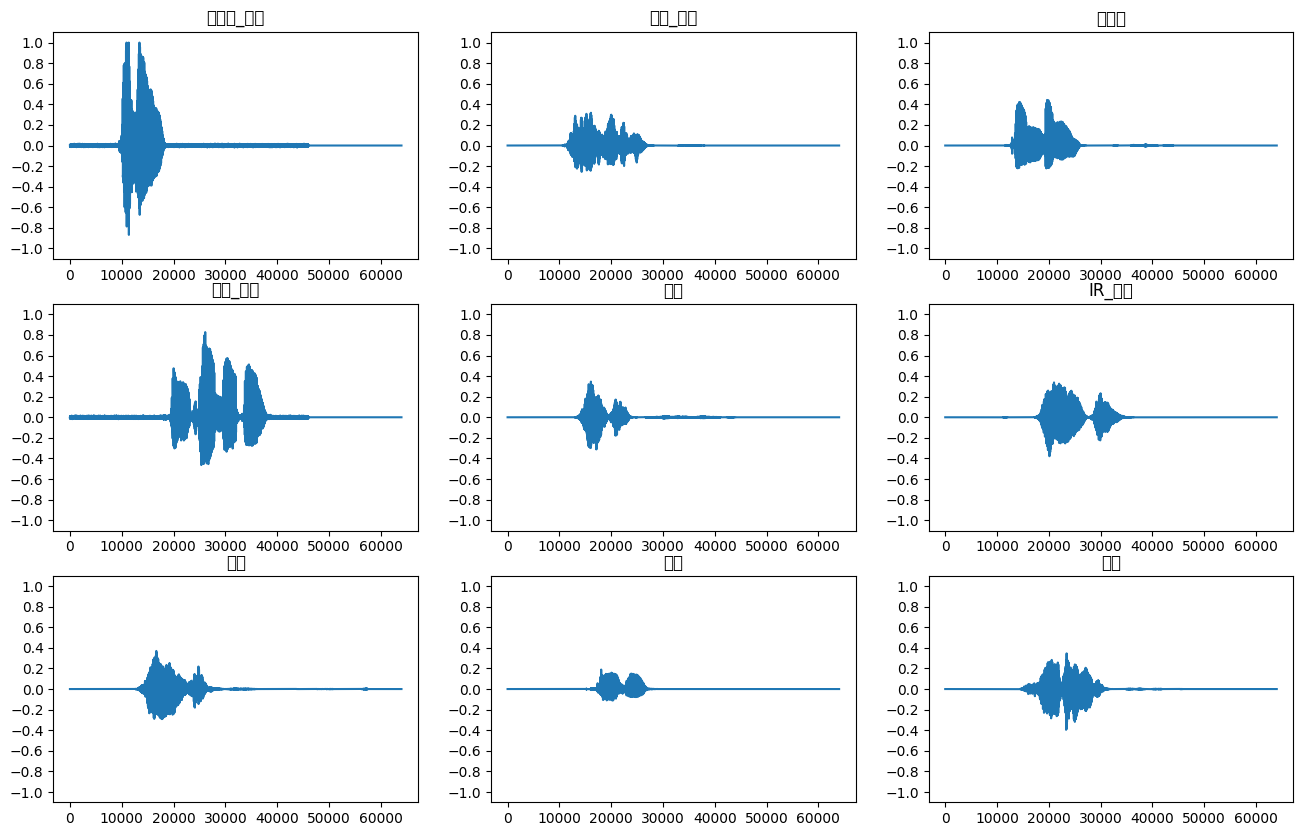

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: 앞으로_이동
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 매우_느림
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: 앞으로
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

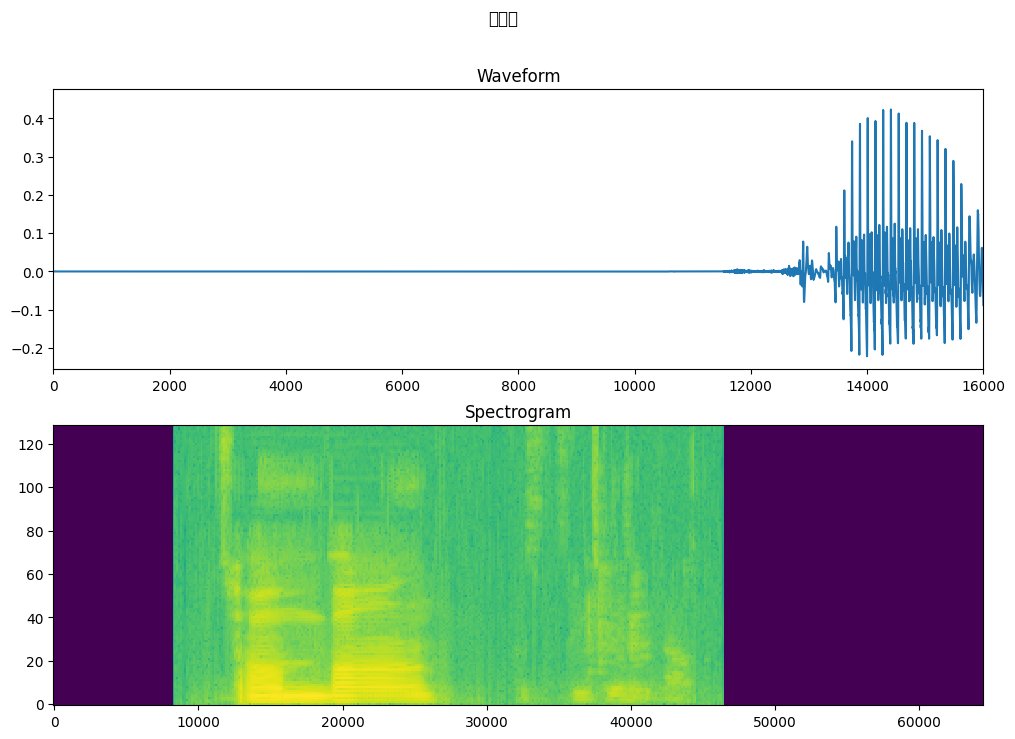

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

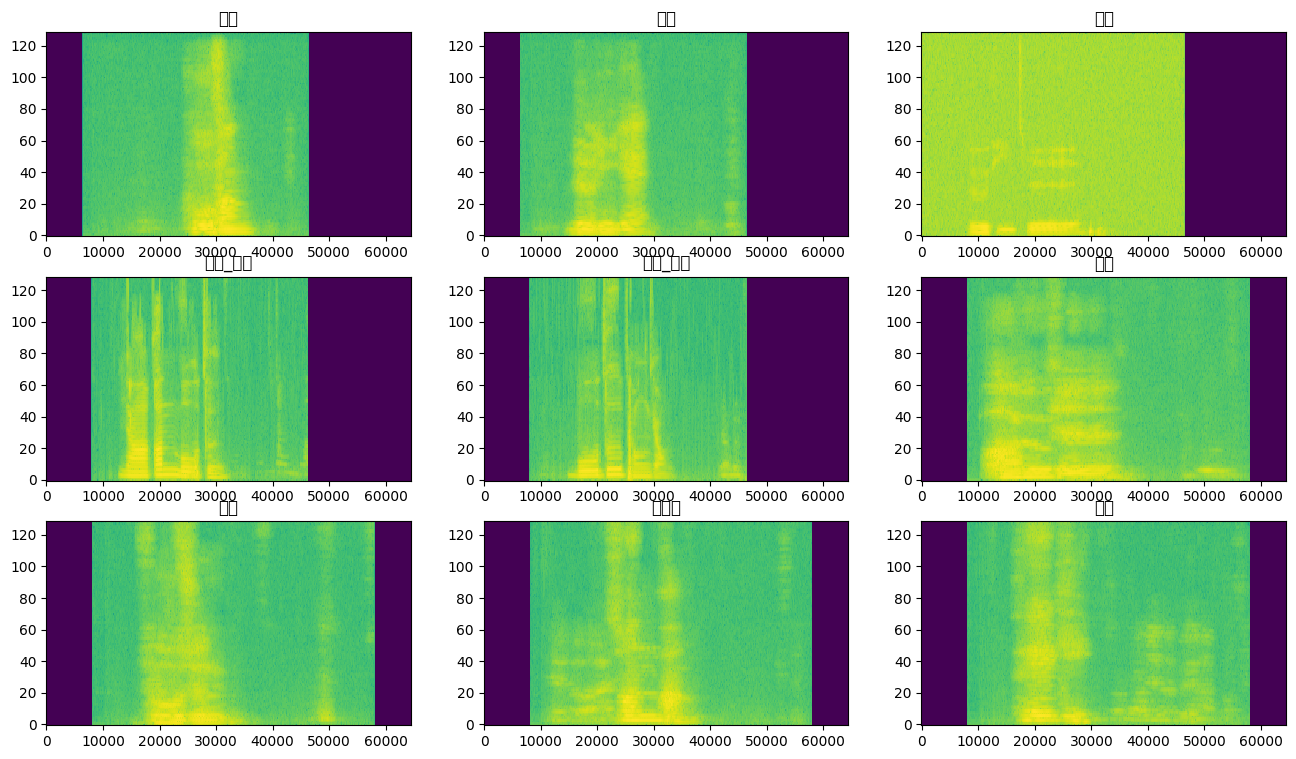

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,707 (6.21 MB)

 Trainable params: 1,628,704 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [ ]:
EPOCHS = 1
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - accuracy: 0.0572 - loss: 3.4203 - val_accuracy: 0.2422 - val_loss: 3.1297


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

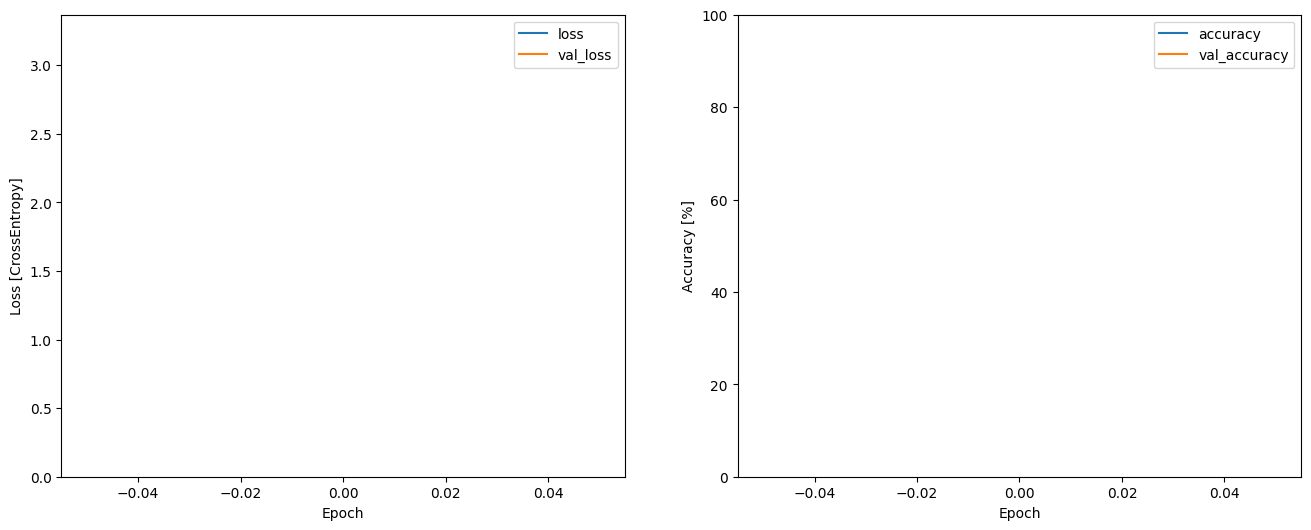

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.2885 - loss: 3.0545


{'accuracy': 0.265625, 'loss': 3.0633201599121094}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44732 (\N{HANGUL SYLLABLE GGEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53020 (\N{HANGUL SYLLABLE KYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/

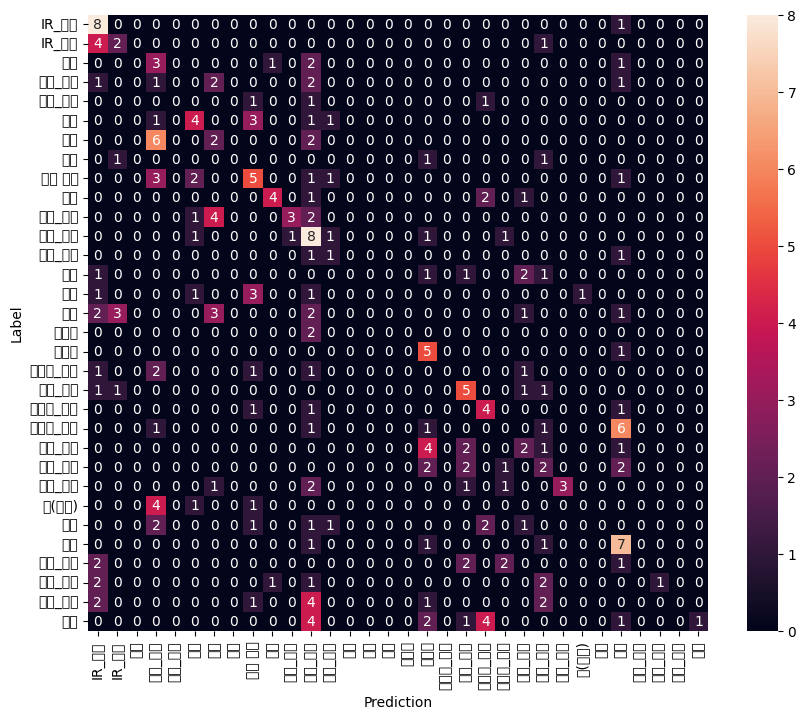

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

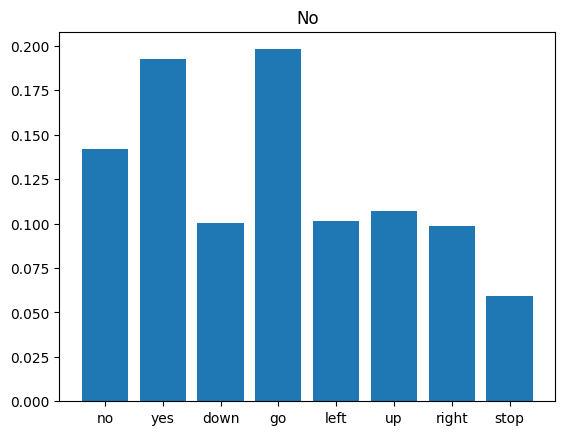

In [ ]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [ ]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.28949296,  0.5936475 , -0.05670966,  0.6212824 , -0.04954294,
          0.00711454, -0.07626566, -0.5835841 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [ ]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.28949296,  0.5936475 , -0.05670966,  0.6212824 , -0.04954294,
          0.00711454, -0.07626566, -0.5835841 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

Found 2395 files belonging to 32 classes.
Using 1916 files for training.
Using 479 files for validation.
Commands (detected folder names): ['IR_꺼짐' 'IR_켜짐' '경고' '경고_모드' '공격_모드' '느림' '대기' '뒤로' '뒤로 이동' '드론' '매우_느림'
 '매우_빠름' '모드_변경' '발사' '복귀' '빠름' '아래에' '앞으로' '앞으로_이동' '야간_모드' '오른쪽_이동'
 '오른쪽_회전' '왼쪽_이동' '왼쪽_회전' '운전_모드' '위(하늘)' '정지' '정찰' '정찰_모드' '조명_꺼짐'
 '조명_켜짐' '조준']
Found 32 classes.
Example audio shape: (64, 64000)
Example labels shape: (64,)
Example labels values: [18 10 17 28  6  0  6 26  7  2  5 16 23 23 20 24 17  2  2 16 26 23 16 19
  5 26 30  9  1  3  2 26 21  8  5  0  6 18 27 18 22 28 29  1 22 21  1 20
  3  8 21 19 28  5 20 16 23 14  6 20 12 17 10 27]


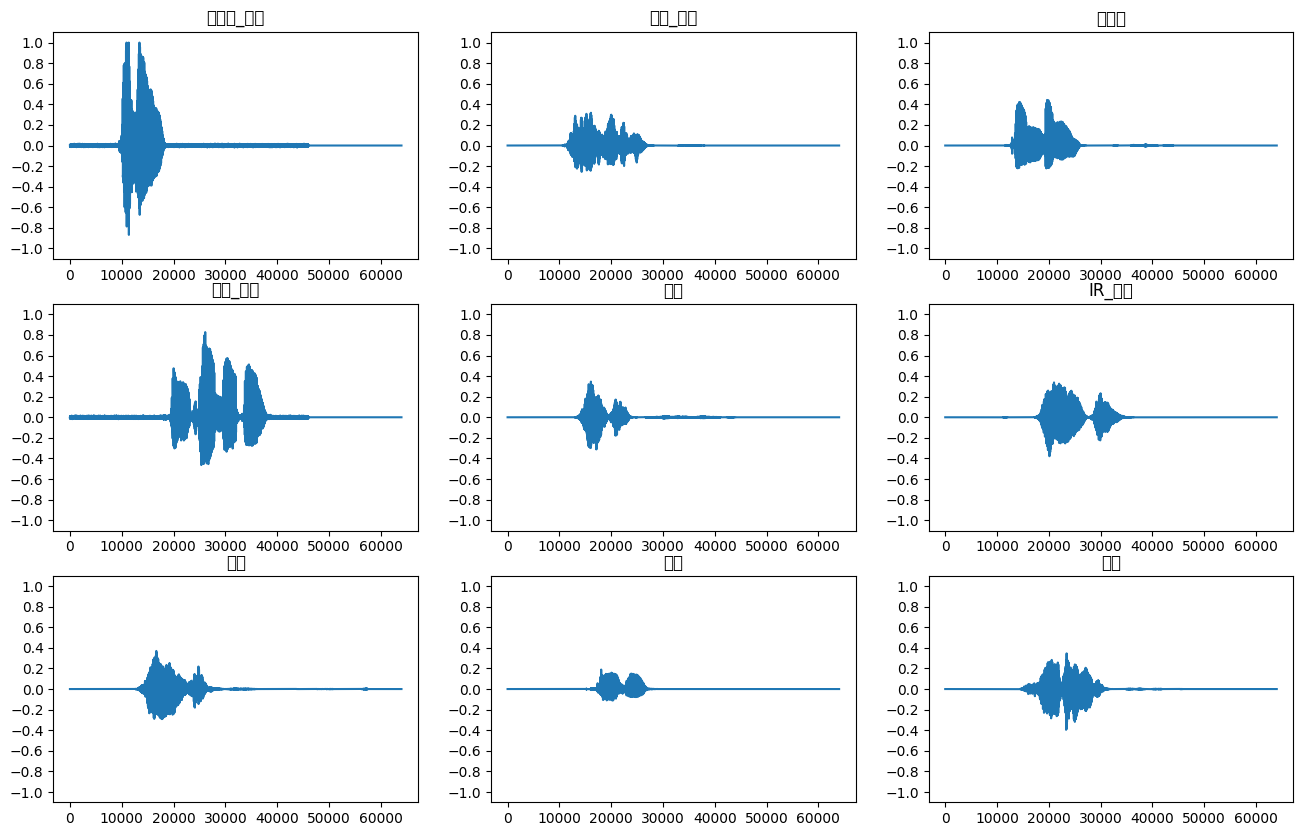

Label: 앞으로_이동
Waveform shape: (64000,)
Spectrogram shape: (171, 560, 1)
Audio playback


Label: 매우_느림
Waveform shape: (64000,)
Spectrogram shape: (171, 560, 1)
Audio playback


Label: 앞으로
Waveform shape: (64000,)
Spectrogram shape: (171, 560, 1)
Audio playback


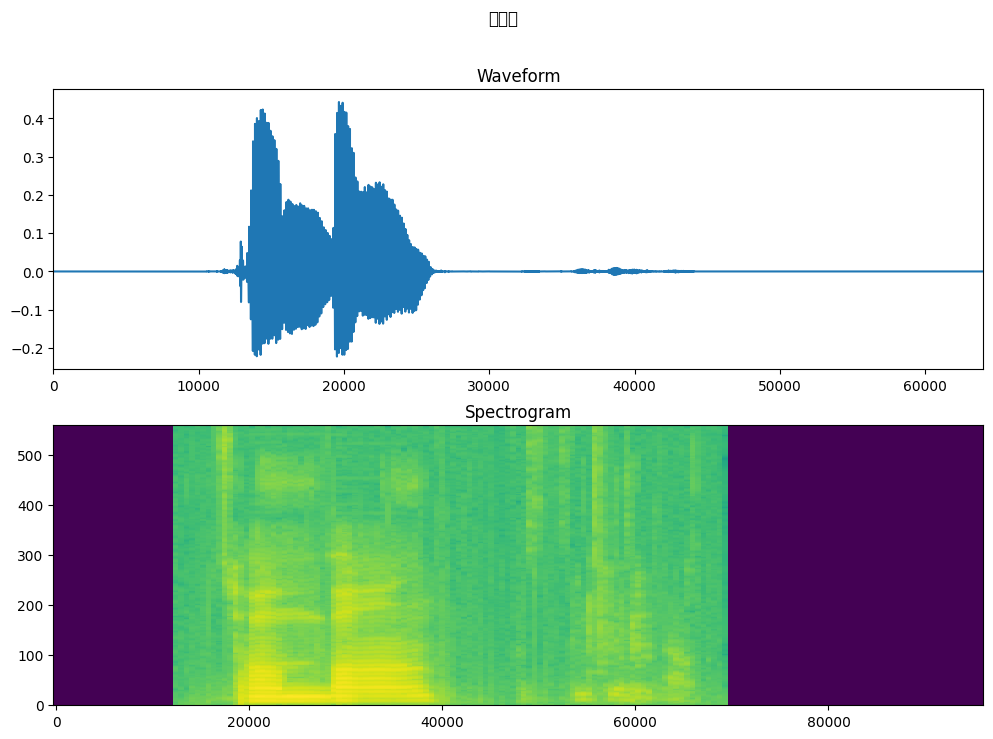

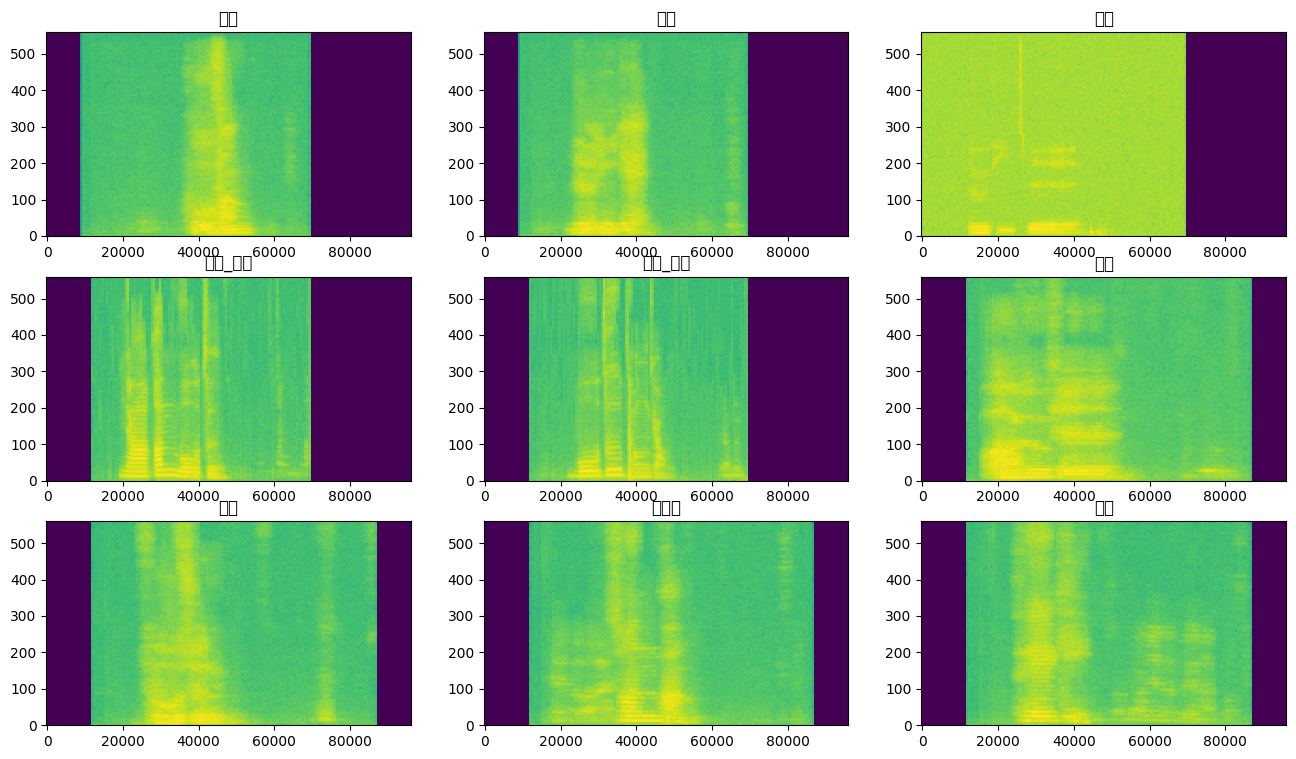

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 171, 560, 1)    │       191,521 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 171, 560, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 86, 280, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 86, 280, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 140, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 43, 140, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 385280)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    49,315,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,530,433 (188.94 MB)

 Trainable params: 49,338,912 (188.21 MB)

 Non-trainable params: 191,521 (748.13 KB)

30/30 ━━━━━━━━━━━━━━━━━━━━ 336s 11s/step - accuracy: 0.0332 - loss: 7.7487 - val_accuracy: 0.0493 - val_loss: 3.4608


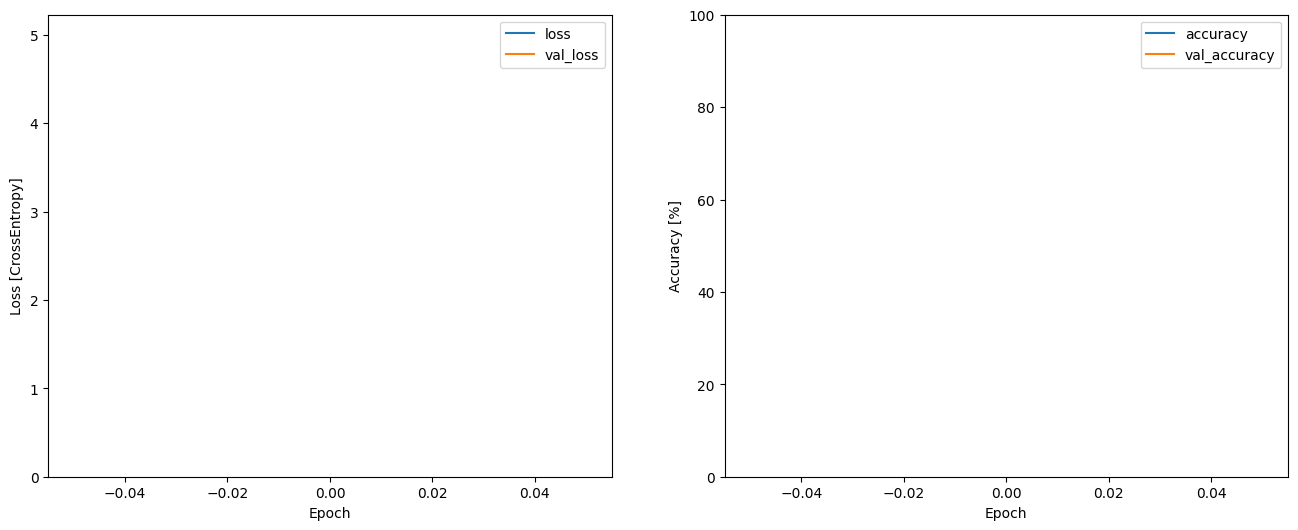

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.0323 - loss: 3.4586
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44732 (\N{HANGUL SYLLABLE GGEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53020 (\N{HANGUL SYLLABLE KYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/

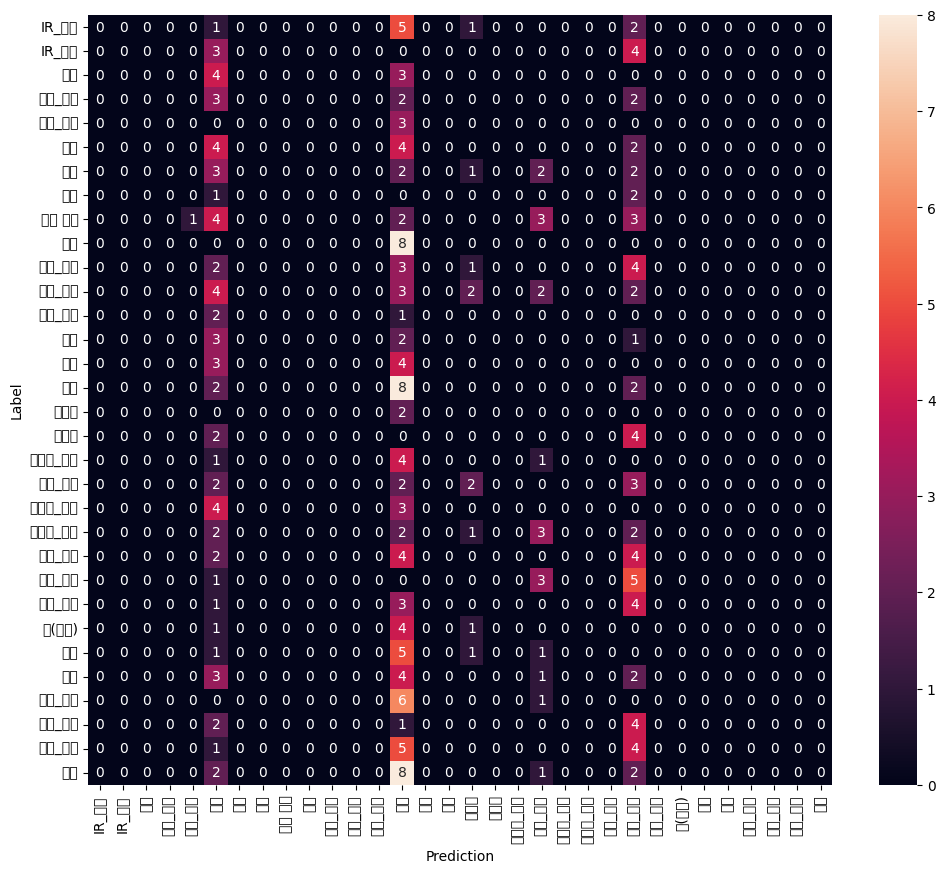

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/korean_speech_commands/only_command/조준/1.wav; No such file or directory [Op:ReadFile]

In [ ]:
# -*- coding: utf-8 -*-
"""Korean_Speech_Recognition_Dynamic_Labels.ipynb

Adapted from https://www.tensorflow.org/tutorials/audio/simple_audio

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# Install required packages
!pip install -U -q tensorflow tensorflow_datasets tf2onnx

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Define your dataset path
DATASET_PATH = '/content/korean_speech_commands/only_command'  # Replace with your actual path
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    raise ValueError("Dataset path does not exist. Please update DATASET_PATH.")

# Load dataset with fixed length (dynamically determined labels)
MAX_AUDIO_SECONDS = 4
SAMPLE_RATE = 16000
OUTPUT_SEQ_LEN = MAX_AUDIO_SECONDS * SAMPLE_RATE  # 64000 samples (4 seconds)
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=seed,
    output_sequence_length=OUTPUT_SEQ_LEN,  # Fixed length
    subset='both')

# Dynamically get label names from the dataset
label_names = np.array(train_ds.class_names)
num_labels = len(label_names)
print('Commands (detected folder names):', label_names)
print(f"Found {num_labels} classes.")

# Squeeze and pad (already handled by output_sequence_length)
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Split validation set into val and test
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Verify shapes
for example_audio, example_labels in train_ds.take(1):
    print("Example audio shape:", example_audio.shape)  # Should be [64, 64000]
    print("Example labels shape:", example_labels.shape)
    print("Example labels values:", example_labels.numpy())  # Debug label values

# Plot a few waveforms
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()

# Convert waveforms to spectrograms with fixed resize to [171, 560]
def get_spectrogram(waveform):
    # STFT
    spectrogram = tf.signal.stft(
        waveform, frame_length=400, frame_step=128, fft_length=512)
    spectrogram = tf.abs(spectrogram)
    # Resize to [171, 560, 1] to match your .rknn model
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [171, 560])
    return spectrogram

# Explore data
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

# Plot spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, OUTPUT_SEQ_LEN])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

# Create spectrogram datasets
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Visualize spectrograms
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.show()

# Cache and prefetch
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build and train the model
input_shape = (171, 560, 1)  # Fixed shape after resizing
norm_layer = layers.Normalization(axis=(1, 2))  # Normalize frequency and channel
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),  # Dynamic number of classes
])

model.summary()

# Compile and train
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 1
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

# Plot training results
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

# Evaluate
model.evaluate(test_spectrogram_ds, return_dict=True)

# Confusion matrix
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

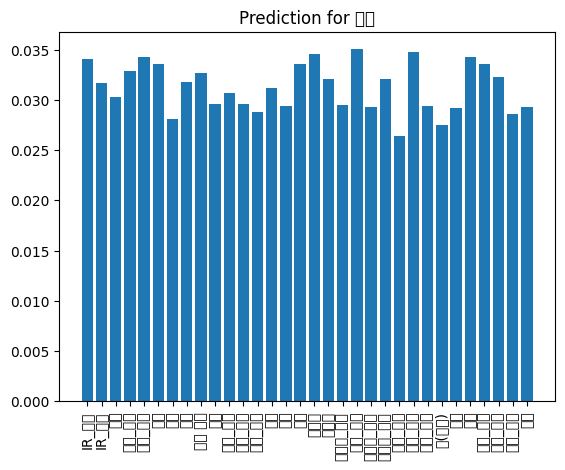

2025-06-18 06:07:29.445332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750226849.505424   44723 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750226849.524082   44723 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750226849.584533   44723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750226849.584595   44723 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750226849.584604   44723 computation_placer.cc:177] computation placer alr

In [ ]:
# Inference on a sample
sample_path = os.path.join(DATASET_PATH, '조준', 'aug_clean_speaker0_Aim_5_stretch.wav')  # Replace with a real file
x = tf.io.read_file(sample_path)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1)
x = tf.squeeze(x, axis=-1)
waveform = x
# Pad or truncate to OUTPUT_SEQ_LEN
waveform = tf.pad(waveform, [[0, OUTPUT_SEQ_LEN - tf.shape(waveform)[0]]])[:OUTPUT_SEQ_LEN]
x = get_spectrogram(waveform)
x = x[tf.newaxis, ...]

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction for 조준')
plt.xticks(rotation=90)
plt.show()
display.display(display.Audio(waveform, rate=16000))

# Export model
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, x):
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1)
            x = tf.squeeze(x, axis=-1)
            # Pad or truncate
            x = tf.pad(x, [[0, OUTPUT_SEQ_LEN - tf.shape(x)[0]]])[:OUTPUT_SEQ_LEN]
        x = get_spectrogram(x)
        x = x[tf.newaxis, ...]
        result = self.model(x, training=False)
        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions': result, 'class_ids': class_ids, 'class_names': class_names}

export = ExportModel(model)
export(tf.constant(sample_path))

# Save and convert to ONNX
tf.saved_model.save(export, "saved_korean_model_dynamic_labels")
!python -m tf2onnx.convert --saved-model saved_korean_model_dynamic_labels --output korean_model_dynamic_labels.onnx --opset 13

### ANOTHER

Found 2395 files belonging to 32 classes.
Using 2156 files for training.
Using 239 files for validation.
Commands (detected folder names): ['IR_꺼짐' 'IR_켜짐' '경고' '경고_모드' '공격_모드' '느림' '대기' '뒤로' '뒤로 이동' '드론' '매우_느림'
 '매우_빠름' '모드_변경' '발사' '복귀' '빠름' '아래에' '앞으로' '앞으로_이동' '야간_모드' '오른쪽_이동'
 '오른쪽_회전' '왼쪽_이동' '왼쪽_회전' '운전_모드' '위(하늘)' '정지' '정찰' '정찰_모드' '조명_꺼짐'
 '조명_켜짐' '조준']
Found 32 classes.
Train dataset size: 34 batches
Validation dataset size: 2 batches
Test dataset size: 2 batches
Example audio shape: (64, 64000)
Example labels shape: (64,)
Example labels values: [ 7  5  5 19 12 15 31 17  6 30  6  1  0  2 12 28 18 27 10 25  8 17  9 17
 15 24 26  5 12 21 17 22 26 24 28 21 24 13 15 11  1 18  2  2 20  0 24 14
  7 21 19 23  7  8 13  9  2 30  4 23 15 16 31 24]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46244 (\N{HANGUL SYLLABLE DWI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47548 (\N{HANGUL SYLLABLE RIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

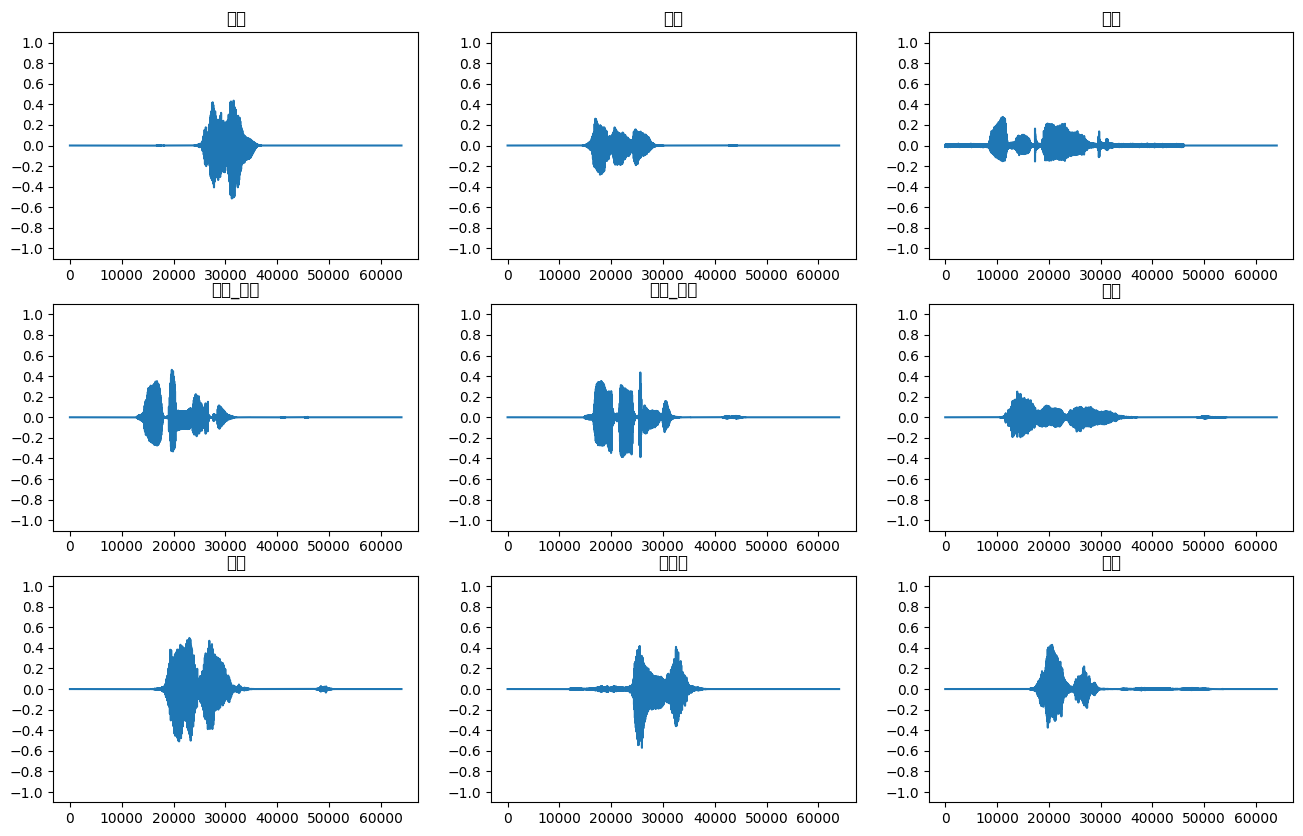

Label: 뒤로
Waveform shape: (64000,)
Spectrogram shape: (171, 560, 1)
Audio playback


Label: 느림
Waveform shape: (64000,)
Spectrogram shape: (171, 560, 1)
Audio playback


Label: 느림
Waveform shape: (64000,)
Spectrogram shape: (171, 560, 1)
Audio playback


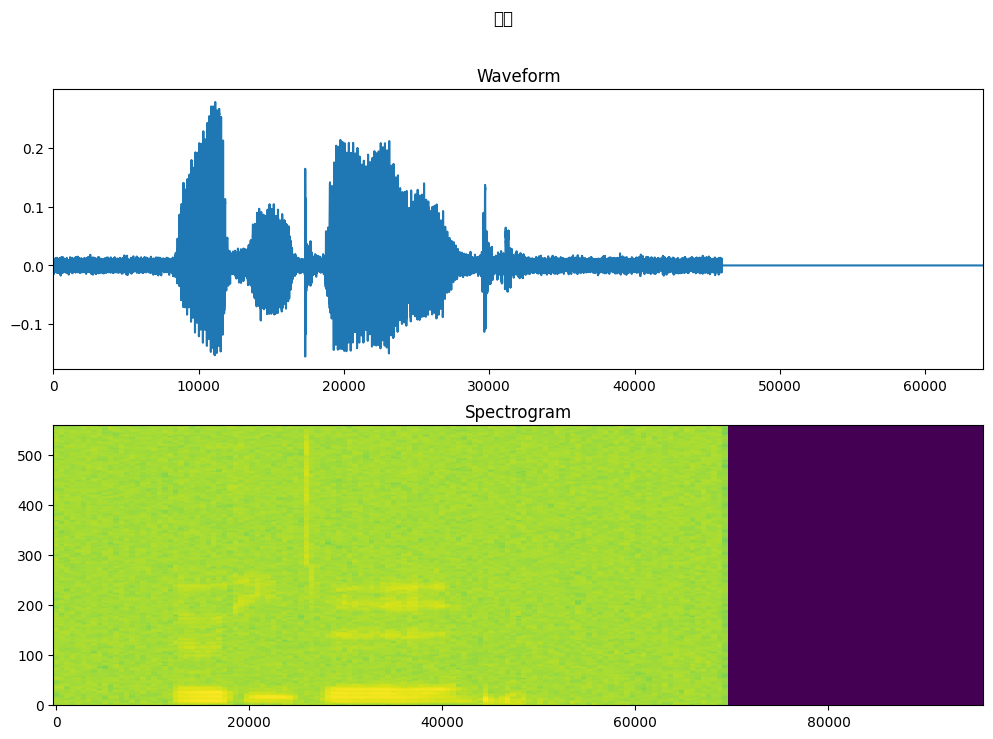

Train spectrogram dataset size: 34 batches
Validation spectrogram dataset size: 2 batches
Test spectrogram dataset size: 2 batches
Example spectrogram shape: (64, 171, 560, 1)
Example spectrogram labels shape: (64,)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47200 (\N{HANGUL SYLLABLE RON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

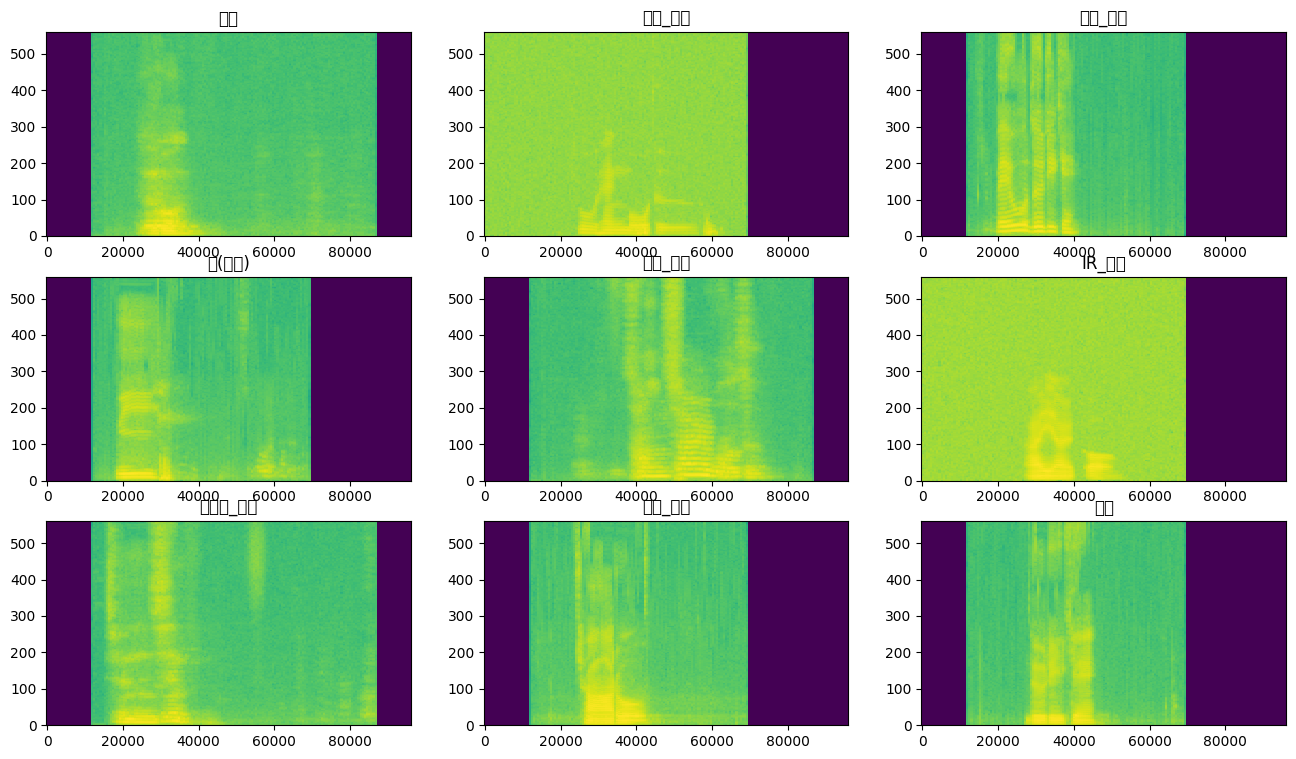

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 171, 560, 1)    │       191,521 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 171, 560, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 86, 280, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 86, 280, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 140, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 43, 140, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 385280)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    49,315,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,530,433 (188.94 MB)

 Trainable params: 49,338,912 (188.21 MB)

 Non-trainable params: 191,521 (748.13 KB)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - accuracy: 0.0520 - loss: 3.8182 - val_accuracy: 0.1712 - val_loss: 3.2558
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.1224 - loss: 3.1985 - val_accuracy: 0.2162 - val_loss: 3.1159
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.1959 - loss: 2.9577 - val_accuracy: 0.2793 - val_loss: 2.8596
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.2938 - loss: 2.5856 - val_accuracy: 0.3694 - val_loss: 2.5663
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.3850 - loss: 2.2533 - val_accuracy: 0.4685 - val_loss: 2.3541
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.4841 - loss: 1.9026 - val_accuracy: 0.5315 - val_loss: 2.0161
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.5858 - loss: 1.5656 - val_accuracy: 0.5676 - val_loss: 1.8979
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.6229 - loss: 1.3470 - val_accuracy

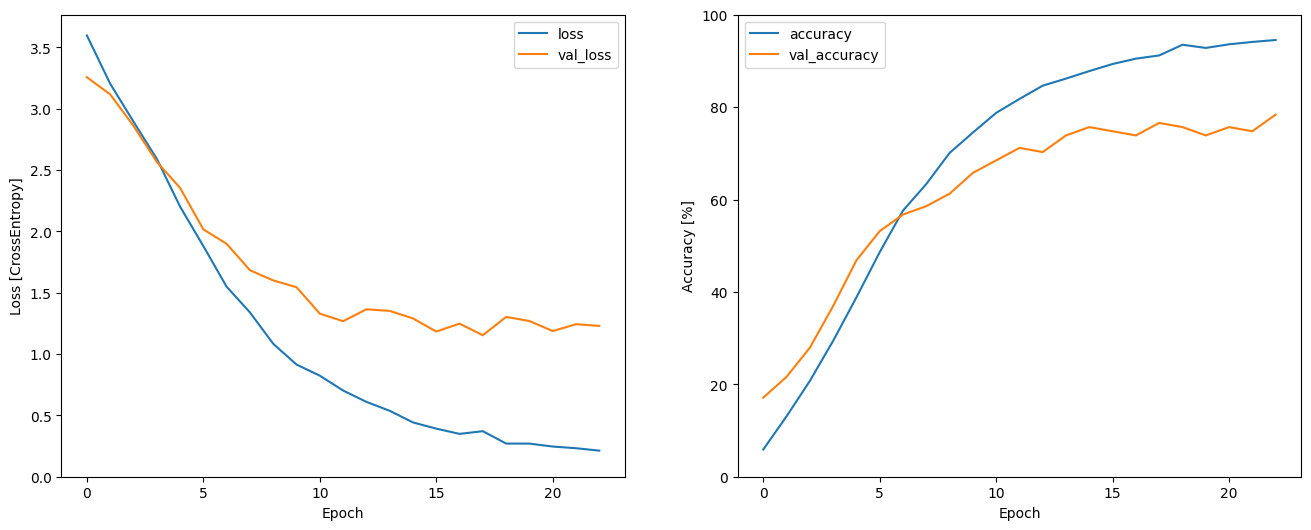

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7552 - loss: 1.2961
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44732 (\N{HANGUL SYLLABLE GGEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53020 (\N{HANGUL SYLLABLE KYEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/

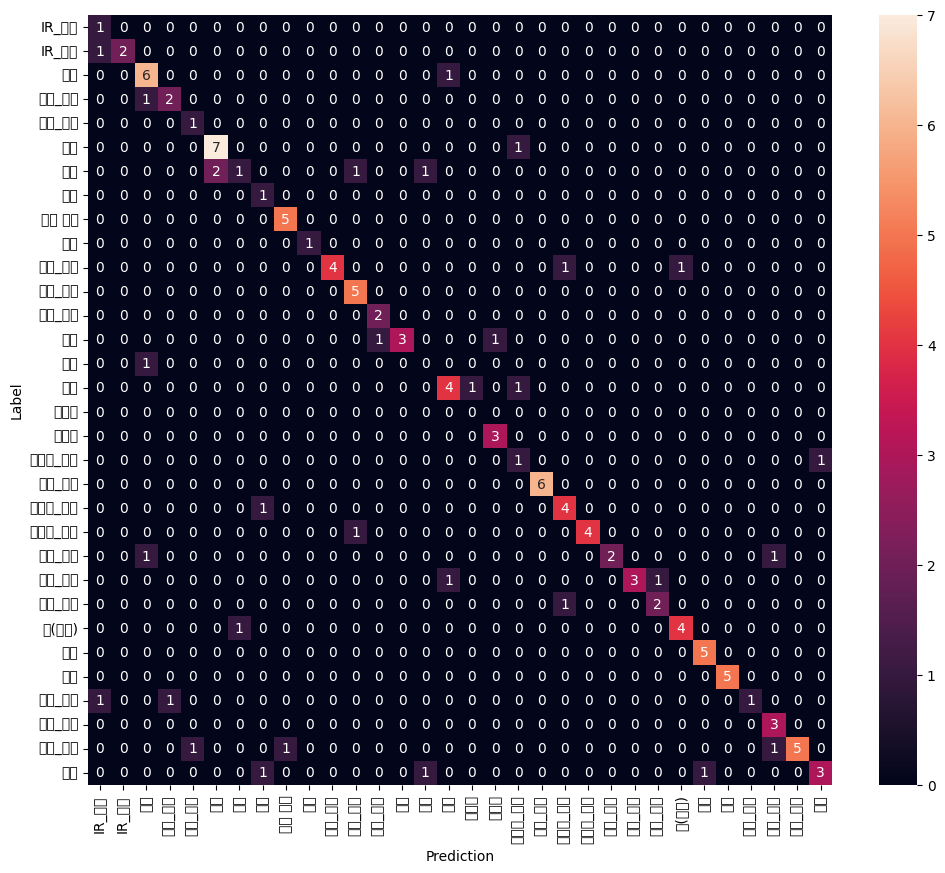

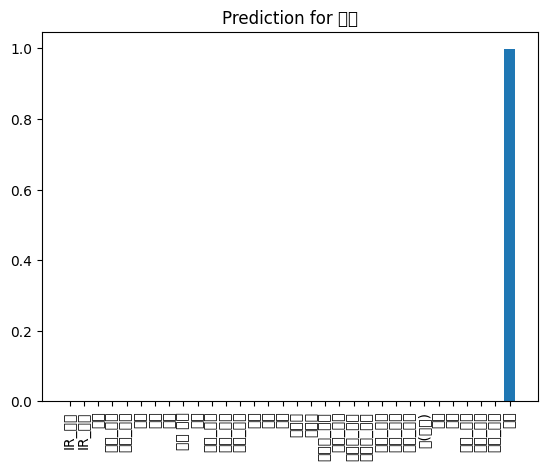

In [ ]:
# -*- coding: utf-8 -*-
"""Korean_Speech_Recognition_Dynamic_Labels.ipynb

Adapted from https://www.tensorflow.org/tutorials/audio/simple_audio

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# Install required packages with updated tf2onnx
# !pip install -U -q tensorflow tensorflow_datasets tf2onnx==1.16.1  # Use latest compatible version

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Define your dataset path
DATASET_PATH = '/content/korean_speech_commands/only_command'  # Replace with your actual path
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    raise ValueError("Dataset path does not exist. Please update DATASET_PATH.")

# Load dataset with fixed length (dynamically determined labels)
MAX_AUDIO_SECONDS = 4
SAMPLE_RATE = 16000
OUTPUT_SEQ_LEN = MAX_AUDIO_SECONDS * SAMPLE_RATE  # 64000 samples (4 seconds)
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.1,
    seed=seed,
    output_sequence_length=OUTPUT_SEQ_LEN,  # Fixed length
    subset='both')

# Dynamically get label names from the dataset
label_names = np.array(train_ds.class_names)
num_labels = len(label_names)
print('Commands (detected folder names):', label_names)
print(f"Found {num_labels} classes.")

# Save labels to a text file
with open('labels.txt', 'w', encoding='utf-8') as f:
    f.write("Detected Label Names:\n")
    for i, label in enumerate(label_names):
        f.write(f"{i}: {label}\n")

# Squeeze and pad (already handled by output_sequence_length)
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Split validation set into val and test with debugging
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Debug dataset sizes
def count_samples(ds):
    return sum(1 for _ in ds)

print(f"Train dataset size: {count_samples(train_ds)} batches")
print(f"Validation dataset size: {count_samples(val_ds)} batches")
print(f"Test dataset size: {count_samples(test_ds)} batches")

# Verify shapes
for example_audio, example_labels in train_ds.take(1):
    print("Example audio shape:", example_audio.shape)
    print("Example labels shape:", example_labels.shape)
    print("Example labels values:", example_labels.numpy())

# Plot a few waveforms
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()

# Convert waveforms to spectrograms with fixed resize to [171, 560]
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=400, frame_step=128, fft_length=512)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], [171, 560])
    return spectrogram

# Explore data
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

# Plot spectrogram
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, OUTPUT_SEQ_LEN])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

# Create spectrogram datasets
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Debug spectrogram dataset sizes
print(f"Train spectrogram dataset size: {count_samples(train_spectrogram_ds)} batches")
print(f"Validation spectrogram dataset size: {count_samples(val_spectrogram_ds)} batches")
print(f"Test spectrogram dataset size: {count_samples(test_spectrogram_ds)} batches")

# Visualize spectrograms
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    print("Example spectrogram shape:", example_spectrograms.shape)
    print("Example spectrogram labels shape:", example_spect_labels.shape)

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.show()

# Cache and prefetch
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build and train the model
input_shape = (171, 560, 1)  # Fixed shape after resizing
norm_layer = layers.Normalization(axis=(1, 2))  # Normalize frequency and channel
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),  # Dynamic number of classes
])

model.summary()

# Compile and train
model.compile(
    # optimizer=tf.keras.optimizers.Adam(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

# Plot training results
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

# Evaluate
model.evaluate(test_spectrogram_ds, return_dict=True)

# Confusion matrix with error handling
try:
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_mtx, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
except Exception as e:
    print(f"Error in confusion matrix computation: {e}")
    print("This may be due to an empty test dataset. Check the dataset size above.")

# Inference on a sample
sample_path = os.path.join(DATASET_PATH, '조준', 'aug_clean_speaker0_Aim_4_volume.wav')  # Replace with a real file
x = tf.io.read_file(sample_path)
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1)
x = tf.squeeze(x, axis=-1)
waveform = x
waveform = tf.pad(waveform, [[0, OUTPUT_SEQ_LEN - tf.shape(waveform)[0]]])[:OUTPUT_SEQ_LEN]
x = get_spectrogram(waveform)
x = x[tf.newaxis, ...]

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction for 조준')
plt.xticks(rotation=90)
plt.show()
display.display(display.Audio(waveform, rate=16000))


In [2]:
# Export model
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, x):
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1)
            x = tf.squeeze(x, axis=-1)
            x = tf.pad(x, [[0, OUTPUT_SEQ_LEN - tf.shape(x)[0]]])[:OUTPUT_SEQ_LEN]
        x = get_spectrogram(x)
        x = x[tf.newaxis, ...]
        result = self.model(x, training=False)
        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions': result, 'class_ids': class_ids, 'class_names': class_names}

export = ExportModel(model)
export(tf.constant(sample_path))

# Save and convert to ONNX with error handling
output_model_path = "saved_korean_model_dynamic_labels"
onnx_model_path = "korean_model_dynamic_labelslr0001.onnx"
tf.saved_model.save(export, output_model_path)
try:
    !python -m tf2onnx.convert --saved-model {output_model_path} --output {onnx_model_path} --opset 13
except Exception as e:
    print(f"Error during ONNX conversion: {e}")
    print("Please ensure tf2onnx is updated to the latest version (e.g., 1.16.1) and compatible with NumPy 2.0.")
    print("You can try downgrading NumPy with: !pip install numpy==1.23.5")

NameError: name 'tf' is not defined